In [2]:
import numpy as np
import scipy.integrate as integrate
import matplotlib.pyplot as plt

import h5py
import os
import json

from sklearn.decomposition import PCA

## Load the data

In [3]:
fluxes = []

f = h5py.File("../training_data/fluxes_tophat.h5", "r")

for key in f.keys():
    fluxes.append(np.array(f[key]))

f.close()

fluxes = np.array(fluxes)

In [43]:
f = h5py.File("../training_data/params_tophat.h5", "r")

params = np.array(f["parameters"])
freqs = np.array(f["frequency"])
ts = np.array(f["time"])

f.close()

## Rescale the data

In [4]:
fluxes = np.log(fluxes)
max_data, min_data = np.max(fluxes,axis =(0,1)), np.min(fluxes, axis = (0,1))


rescaled_data = np.array([((flux-min_data)/(max_data-min_data)).flatten() for flux in fluxes])


In [119]:
rescaled_params = params.copy()
for j in [0,2,5,6]:
    rescaled_params[:, j] = np.log10(params[:,j])


max_params, min_params = np.max(rescaled_params, axis =0), np.min(rescaled_params, axis=0)

rescaled_params = (rescaled_params-min_params)/(max_params - min_params)


We use Principal component analysis to reduce data. For the reconstruction of the data, we need to keep a sufficient amount of components. To find out how many, we ran a test where we load and plot the results here.

Text(0.5, 0, 'data entries')

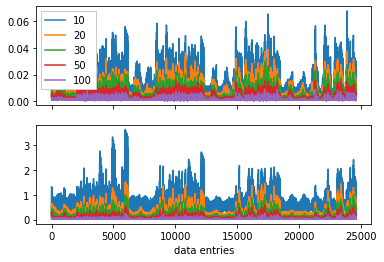

In [92]:
with open("comp_test.json") as f:
    comp_test = json.load(f)


fig, ax = plt.subplots(2,1, figsize = (6,4), sharex = True)
for key in comp_test.keys():
    ax[0].plot(comp_test[key]["max"], label= key)
    ax[1].plot(comp_test[key]["Frobenius"], label = key)

ax[0].legend(fancybox = False, framealpha = 1)
ax[1].set_xlabel("data entries")

In [83]:
np.argmax(comp_test["50"]["max"])

21311

Apparently, some data is harder to recover than other data. Overall, 50 components should be sufficient (maybe 30?).

## Perform data reduction

In [65]:
pca = PCA(n_components=50)
training_data = pca.fit_transform(rescaled_data)
np.sum(pca.explained_variance_ratio_)


0.9999919598548046

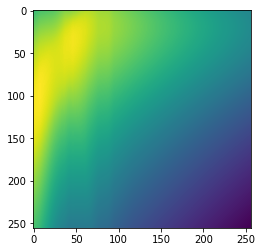

In [84]:
plt.imshow(rescaled_data[21311].reshape(256, 256))

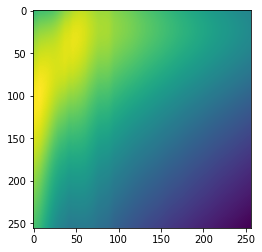

In [85]:
plt.imshow(pca.inverse_transform(training_data[21311]).reshape(256, 256))

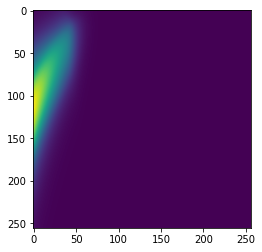

In [108]:
plt.imshow(np.exp(fluxes[21311]))

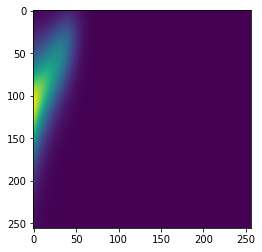

In [109]:
plt.imshow(np.exp(pca.inverse_transform(training_data[21311]).reshape(256, 256)*(max_data-min_data)+min_data))

0.692733649920624
9.937235639554615


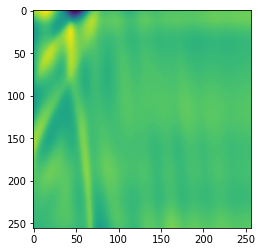

In [114]:
worst_flux = fluxes[21311]
worst_recover = pca.inverse_transform(training_data[21311]).reshape(256, 256)*(max_data-min_data)+min_data

print(np.abs(worst_flux- worst_recover).max())
print(np.linalg.norm(worst_flux-worst_recover))

plt.imshow(np.exp(worst_flux)/np.exp(worst_recover))